In [1]:
%load_ext autoreload
%autoreload 2

from statsmodels.stats.multitest import multipletests
from setup_func import *

In [2]:
path_to_summary = f'{data_dir}/clean_all_group_df_summary.csv'
path_to_longform = f'{data_dir}/clean_all_group_longform.csv'

summary_df = pd.read_csv(path_to_summary, index_col=0)
longform = pd.read_csv(path_to_longform, index_col=0)

alcohol_longform = longform[longform['Group'] == 'alcohol']
cannabis_longform = longform[longform['Group'] == 'cannabis']


In [3]:
batches = {
    'alcohol': None,
    'cannabis': None,
}

## Create Redcap dataframe

In [4]:
master_demo_df = create_master_demo_df()

Loading master_demo_df...


In [6]:
### Calculate mean and std of cravings and mood
copy_master_demo_df = pd.DataFrame()
for group in ['Alcohol', 'Cannabis']:
    group_master_demo_df = master_demo_df.loc[master_demo_df['Group'] == group]
    for block in ['other', 'money']:
        mean_craving_ratings = []
        std_craving_ratings = []
        mean_mood_ratings = [] 
        std_mood_ratings = []
        for pid in group_master_demo_df['PID'].unique():
            if pid in longform['PID'].unique():
                raw_cravings = longform[
                    (longform['PID']==pid) &
                    (longform['Group']==group.lower()) &
                    (longform['Type']==block) &
                    (longform['Craving Rating']!=-1) 
                ]['Craving Rating'].values
                mean_craving_ratings.append(np.mean(raw_cravings))
                std_craving_ratings.append(np.std(raw_cravings))

                raw_mood_ratings = longform[
                    (longform['PID']==pid) &
                    (longform['Group']==group.lower()) &
                    (longform['Type']==block) &
                    (longform['Mood Rating']!=-1)
                ]['Mood Rating'].values
                mean_mood_ratings.append(np.mean(raw_mood_ratings))
                std_mood_ratings.append(np.std(raw_mood_ratings))
            else:
                print(f'PID {pid} not found in longform data')

        group_master_demo_df[f'mean_craving_ratings_{block}'] = mean_craving_ratings
        group_master_demo_df[f'std_craving_ratings_{block}'] = std_craving_ratings
        group_master_demo_df[f'mean_mood_ratings_{block}'] = mean_mood_ratings
        group_master_demo_df[f'std_mood_ratings_{block}'] = std_mood_ratings
    copy_master_demo_df = pd.concat([copy_master_demo_df, group_master_demo_df])
master_demo_df = copy_master_demo_df

## EMFit for all alcohol data

In [7]:
if os.path.exists(f'{decision_results_dir}/alcohol_decision_models.pkl'):
    print('Loading existing decision models')
    with open(f'{decision_results_dir}/alcohol_decision_models.pkl', 'rb') as f:
        modout = pickle.load(f)


Loading existing decision models


In [8]:
fitted_craving_modout = {}
fitted_craving_modout['alcohol_other'] = {}
# fitted_craving_modout['cannabis'] = {}

chosen_model = 'd_lrbias_rw'
block = 'other'

save_fit_path=f'{results_dir}/craving/'
if not os.path.exists(craving_results_dir):
    os.makedirs(craving_results_dir)
if os.path.exists(f'{craving_results_dir}/alcohol_{chosen_model}_{block}_craving_models.pkl'):
    print('Loading existing craving models')
    with open(f'{craving_results_dir}/alcohol_{chosen_model}_{block}_craving_models.pkl', 'rb') as f:
        fitted_craving_modout['alcohol_other'] = pickle.load(f)
# if os.path.exists(f'{craving_results_dir}/cannabis_{chosen_model}_{block}_craving_models.pkl'):
#     print('Loading existing craving models')
#     with open(f'{craving_results_dir}/cannabis_{chosen_model}_{block}_craving_models.pkl', 'rb') as f:
#         fitted_craving_modout['cannabis'] = pickle.load(f)

chosen_model = 'o_add_rewbias_rw'
block = 'money'
if os.path.exists(f'{craving_results_dir}/alcohol_{chosen_model}_{block}_craving_models.pkl'):
    print('Loading existing craving models')
    with open(f'{craving_results_dir}/alcohol_{chosen_model}_{block}_craving_models.pkl', 'rb') as f:
        fitted_craving_modout['alcohol_money'] = pickle.load(f)
# if os.path.exists(f'{craving_results_dir}/cannabis_{chosen_model}_{block}_craving_models.pkl'):
#     print('Loading existing craving models')
#     with open(f'{craving_results_dir}/cannabis_{chosen_model}_{block}_craving_models.pkl', 'rb') as f:
#         fitted_craving_modout['cannabis'] = pickle.load(f)

fitted_craving_modout.keys()

Loading existing craving models
Loading existing craving models


dict_keys(['alcohol_other', 'alcohol_money'])

In [9]:
param_df = pd.DataFrame()

for decision_model, block in zip(['d_lrbias_rw', 'o_add_rewbias_rw'], ['other', 'money']):
    for pid, params in zip(alcohol_longform['PID'].unique(), modout[f'{decision_model}_{block}']['fit']['params']):
        beta, alpha, mod = params
        param_df = pd.concat([param_df, pd.DataFrame({
            'PID': [pid],
            # 'Block': [block],
            'Param': [f'alpha_{block}'],
            'Value': [alpha]
        })], ignore_index=True)
        param_df = pd.concat([param_df, pd.DataFrame({
            'PID': [pid],
            # 'Block': [block],
            'Param': [f'beta_{block}'],
            'Value': [beta]
        })], ignore_index=True)
        param_df = pd.concat([param_df, pd.DataFrame({
            'PID': [pid],
            # 'Block': [block],
            'Param': [f'mod_{block}'],
            'Value': [mod]
        })], ignore_index=True)

for block in ['other', 'money']:
    for pid, params in zip(alcohol_longform['PID'].unique(), fitted_craving_modout[f'alcohol_{block}'][f'f_ev_rpe_geodecay_{block}']['fit']['params']):
        craving_baseline, ev_weight, rpe_weight = params
        # param_df = pd.concat([param_df, pd.DataFrame({
        #     'PID': [pid],
        #     # 'Block': [block],
        #     'Param': [f'gamma_{block}'],
        #     'Value': [gamma]
        # })], ignore_index=True)
        param_df = pd.concat([param_df, pd.DataFrame({
            'PID': [pid],
            # 'Block': [block],
            'Param': [f'craving_baseline_{block}'],
            'Value': [craving_baseline]
        })], ignore_index=True)
        param_df = pd.concat([param_df, pd.DataFrame({
            'PID': [pid],
            # 'Block': [block],
            'Param': [f'ev_weight_{block}'],
            'Value': [ev_weight]
        })], ignore_index=True)
        param_df = pd.concat([param_df, pd.DataFrame({
            'PID': [pid],
            # 'Block': [block],
            'Param': [f'rpe_weight_{block}'],
            'Value': [rpe_weight]
        })], ignore_index=True)

pivot_param_df = pd.pivot_table(param_df, index=['PID'], columns='Param', values='Value').reset_index()

pivot_param_df

Param,PID,alpha_money,alpha_other,beta_money,beta_other,craving_baseline_money,craving_baseline_other,ev_weight_money,ev_weight_other,mod_money,mod_other,rpe_weight_money,rpe_weight_other
0,56849d528f456f000c45e1dd,0.751057,0.735298,1.554839,1.236585,24.720673,24.668606,0.022699,0.020027,0.092339,0.230134,0.408311,-0.177956
1,57dd766bbcd7150001ded5de,0.548770,0.766810,4.702280,5.429772,13.271447,9.284630,-0.083691,-0.084877,0.074286,-0.969466,0.888292,0.760829
2,58064d91f25c440001678a10,0.850620,0.602237,5.424106,6.007890,5.153111,0.941932,-0.554143,1.137862,-0.007605,0.450314,-0.163243,2.137052
3,58a43e029a17120001d910d5,0.721405,0.698601,6.565132,4.766500,17.807968,28.734259,1.061571,0.004661,0.096167,-0.362709,3.284530,0.065292
4,58cbd23d5d42920001414dd8,0.831791,0.777380,6.177649,4.984520,0.953127,3.056166,0.009828,-0.189317,0.085856,1.433036,-0.037124,-0.462109
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,62b20575b356fba8715fae82,0.691889,0.782009,2.928799,2.042133,23.391387,24.389790,0.143181,-0.060534,0.044441,1.006703,-0.085797,-0.045883
64,62bdfe451d380bec13a4a864,0.592263,0.755612,1.768147,1.700733,1.740342,0.634238,-0.052053,0.028627,0.115491,0.411460,-1.366289,1.339956
65,62d6d903bfa2edd3d7f58d82,0.807419,0.824284,1.364565,2.839666,8.120793,9.166761,0.035430,-0.001589,0.123118,0.956823,1.205922,0.005099
66,62e02660c3ef175825ab7655,0.484265,0.740952,7.199012,2.208306,0.006743,1.746889,0.054270,-0.080539,-0.160807,0.503544,-2.126473,1.560342


In [10]:
# alcohol_merged = pd.merge(joined_dfs['alcohol'], pivot_param_df, left_on='PID', right_on='PID', how='inner')
alcohol_merged = pd.merge(master_demo_df, pivot_param_df, left_on='PID', right_on='PID', how='inner')
alcohol_merged.columns

Index(['ASSIST_Alcohol', 'ASSIST_Freq', 'ASSIST_Craving', 'ASSIST_StopAttempt',
       'age', 'sex', 'edu_level', 'income', 'race', 'PID', 'id', 'Other Key',
       'Block Order', 'Reversal Timings', 'Base Craving', 'Base Mood',
       'Timestamp', 'Money Accuracy', 'Other Accuracy', 'Group', 'Round',
       'Money Score', 'Other Score', 'ASSIST_Cannabis', 'DEMO_age', 'DEMO_sex',
       'DEMO_edu', 'DEMO_income', 'DEMO_race', 'mean_craving_ratings_other',
       'std_craving_ratings_other', 'mean_mood_ratings_other',
       'std_mood_ratings_other', 'mean_craving_ratings_money',
       'std_craving_ratings_money', 'mean_mood_ratings_money',
       'std_mood_ratings_money', 'alpha_money', 'alpha_other', 'beta_money',
       'beta_other', 'craving_baseline_money', 'craving_baseline_other',
       'ev_weight_money', 'ev_weight_other', 'mod_money', 'mod_other',
       'rpe_weight_money', 'rpe_weight_other'],
      dtype='object')

Correlation between beta_other and ASSIST Alcohol score: -0.293, p-value: 0.015
Correlation between alpha_other and ASSIST Alcohol score: 0.245, p-value: 0.044
Correlation between mod_other and ASSIST Alcohol score: 0.096, p-value: 0.435
Correlation between craving_baseline_other and ASSIST Alcohol score: 0.280, p-value: 0.021
Correlation between ev_weight_other and ASSIST Alcohol score: -0.108, p-value: 0.381
Correlation between rpe_weight_other and ASSIST Alcohol score: -0.154, p-value: 0.211

Corrected p-values: [0.06155755 0.0883094  0.4354358  0.06155755 0.4354358  0.31660609]


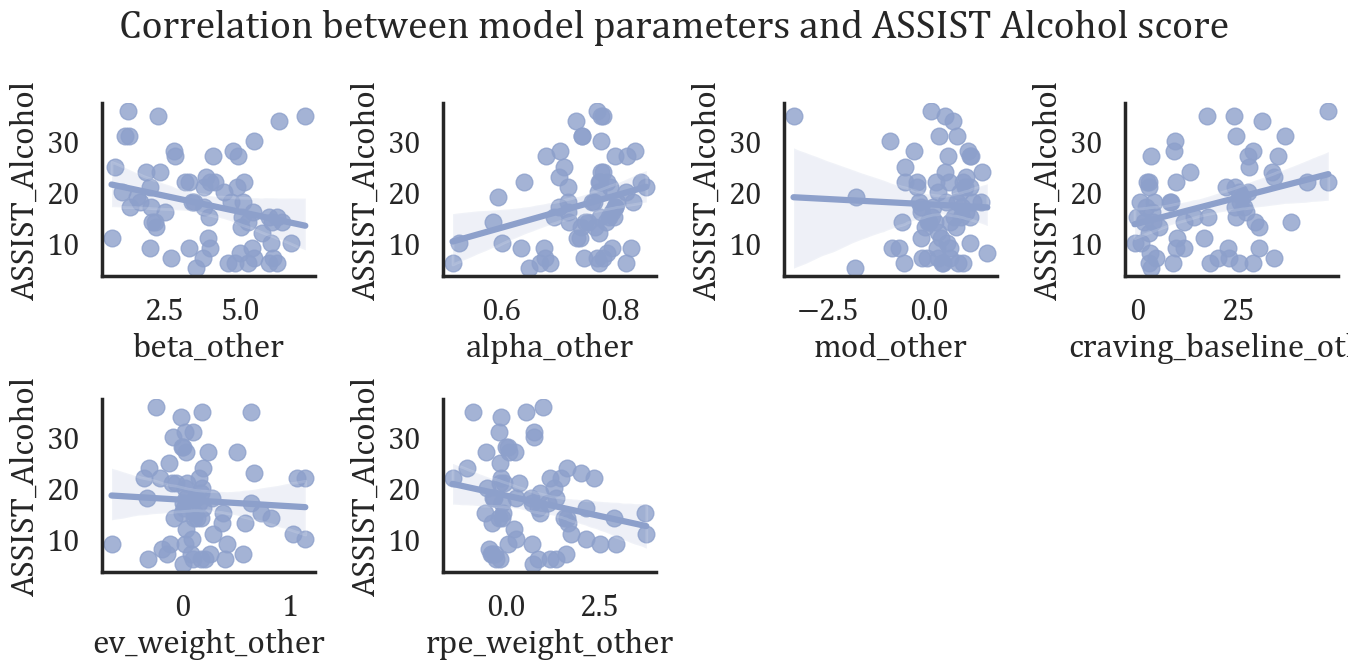

In [11]:
# Seaborn correlation plot
params_to_corr = [param+'_other' for param in ['beta', 'alpha', 'mod', 'craving_baseline', 'ev_weight', 'rpe_weight']]
pvals = []

fig, ax = plt.subplots(2, 4, figsize=(14,7))
ax = ax.flatten()
for i, param in enumerate(params_to_corr):

    sns.regplot(data=alcohol_merged, x=param, y='ASSIST_Alcohol', ax=ax[i], color=sns.palettes.color_palette('Set2')[2])
    # Annotate with correlation value and p-value
    corr_val, p_val = stats.spearmanr(alcohol_merged[param], alcohol_merged['ASSIST_Alcohol'])
    pvals.append(p_val)
    # ax[i].annotate(f'Corr: {corr_val:.3f}\nP: {p_val:.3f}', xy=(0.1, 0.85), xycoords='axes fraction', color=sns.palettes.color_palette('Set2')[2])
    print(f'Correlation between {param} and ASSIST Alcohol score: {corr_val:.3f}, p-value: {p_val:.3f}')

    

fig.suptitle('Correlation between model parameters and ASSIST Alcohol score')
fig.delaxes(ax[-1])
fig.delaxes(ax[-2])
sns.despine()
plt.tight_layout()
print()
print(f'Corrected p-values: {multipletests(pvals, method="fdr_bh")[1]}')

Correlation between beta_money and ASSIST Alcohol score: -0.242, p-value: 0.047
Correlation between alpha_money and ASSIST Alcohol score: -0.059, p-value: 0.630
Correlation between mod_money and ASSIST Alcohol score: -0.091, p-value: 0.459
Correlation between craving_baseline_money and ASSIST Alcohol score: 0.386, p-value: 0.001
Correlation between ev_weight_money and ASSIST Alcohol score: -0.080, p-value: 0.515
Correlation between rpe_weight_money and ASSIST Alcohol score: -0.050, p-value: 0.687

Corrected p-values: [0.14048715 0.68706601 0.68706601 0.00686081 0.68706601 0.68706601]


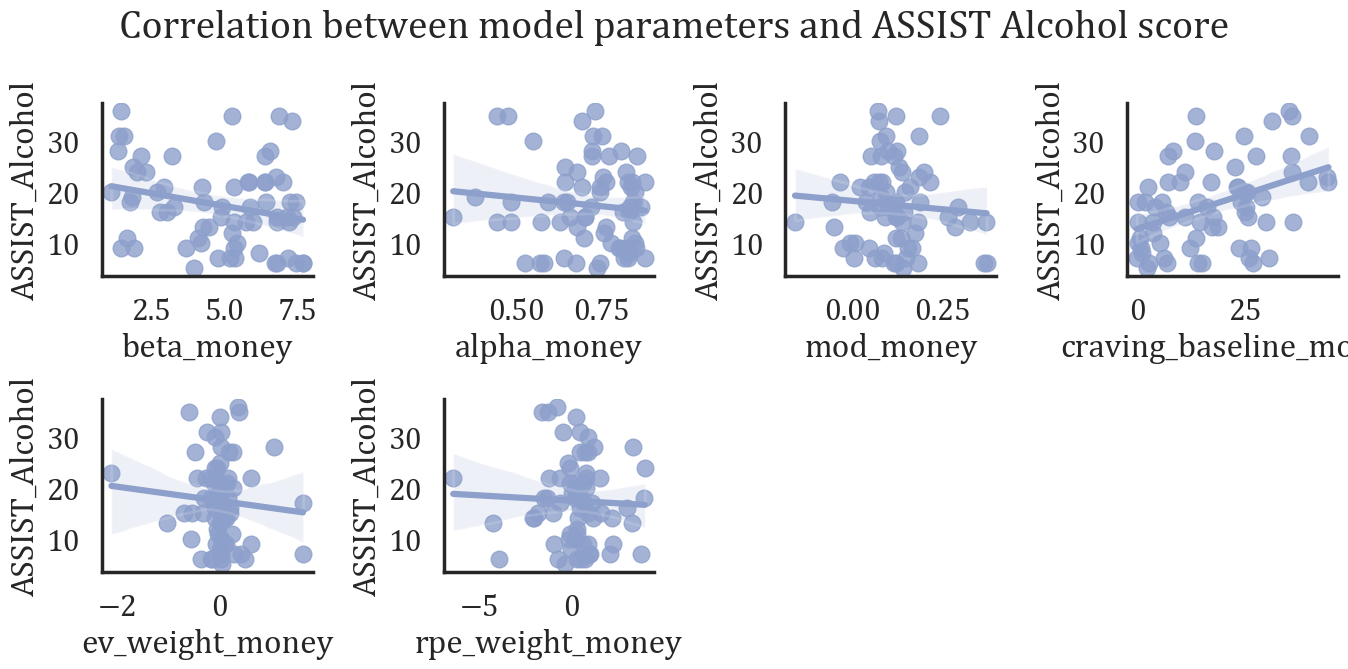

In [12]:
# Seaborn correlation plot
params_to_corr = [param+'_money' for param in ['beta', 'alpha', 'mod', 'craving_baseline', 'ev_weight', 'rpe_weight']]
pvals = []

fig, ax = plt.subplots(2, 4, figsize=(14,7))
ax = ax.flatten()
for i, param in enumerate(params_to_corr):

    sns.regplot(data=alcohol_merged, x=param, y='ASSIST_Alcohol', ax=ax[i], color=sns.palettes.color_palette('Set2')[2])
    # Annotate with correlation value and p-value
    corr_val, p_val = stats.spearmanr(alcohol_merged[param], alcohol_merged['ASSIST_Alcohol'])
    pvals.append(p_val)
    # ax[i].annotate(f'Corr: {corr_val:.3f}\nP: {p_val:.3f}', xy=(0.1, 0.85), xycoords='axes fraction', color=sns.palettes.color_palette('Set2')[2])
    print(f'Correlation between {param} and ASSIST Alcohol score: {corr_val:.3f}, p-value: {p_val:.3f}')

    

fig.suptitle('Correlation between model parameters and ASSIST Alcohol score')
fig.delaxes(ax[-1])
fig.delaxes(ax[-2])
sns.despine()
plt.tight_layout()
print()
print(f'Corrected p-values: {multipletests(pvals, method="fdr_bh")[1]}')

## EMFit for all cannabis data

In [13]:
if os.path.exists(f'{decision_results_dir}/cannabis_decision_models.pkl'):
    print('Loading existing decision models')
    with open(f'{decision_results_dir}/cannabis_decision_models.pkl', 'rb') as f:
        modout = pickle.load(f)


Loading existing decision models


In [14]:
fitted_craving_modout = {}
# fitted_craving_modout['alcohol_other'] = {}
# fitted_craving_modout['cannabis'] = {}

chosen_model = 'd_lrbias_rw'
block = 'other'

if os.path.exists(f'{craving_results_dir}/cannabis_{chosen_model}_{block}_craving_models.pkl'):
    print('Loading existing craving models')
    with open(f'{craving_results_dir}/cannabis_{chosen_model}_{block}_craving_models.pkl', 'rb') as f:
        fitted_craving_modout['cannabis_other'] = pickle.load(f)
# if os.path.exists(f'{craving_results_dir}/cannabis_{chosen_model}_{block}_craving_models.pkl'):
#     print('Loading existing craving models')
#     with open(f'{craving_results_dir}/cannabis_{chosen_model}_{block}_craving_models.pkl', 'rb') as f:
#         fitted_craving_modout['cannabis'] = pickle.load(f)

chosen_model = 'o_add_rewbias_rw'
block = 'money'
if os.path.exists(f'{craving_results_dir}/cannabis_{chosen_model}_{block}_craving_models.pkl'):
    print('Loading existing craving models')
    with open(f'{craving_results_dir}/cannabis_{chosen_model}_{block}_craving_models.pkl', 'rb') as f:
        fitted_craving_modout['cannabis_money'] = pickle.load(f)
# if os.path.exists(f'{craving_results_dir}/cannabis_{chosen_model}_{block}_craving_models.pkl'):
#     print('Loading existing craving models')
#     with open(f'{craving_results_dir}/cannabis_{chosen_model}_{block}_craving_models.pkl', 'rb') as f:
#         fitted_craving_modout['cannabis'] = pickle.load(f)

fitted_craving_modout.keys()

Loading existing craving models
Loading existing craving models


dict_keys(['cannabis_other', 'cannabis_money'])

In [15]:
param_df = pd.DataFrame()

for decision_model, block in zip(['d_lrbias_rw', 'o_add_rewbias_rw'], ['other', 'money']):
    for pid, params in zip(cannabis_longform['PID'].unique(), modout[f'{decision_model}_{block}']['fit']['params']):
        beta, alpha, mod = params
        param_df = pd.concat([param_df, pd.DataFrame({
            'PID': [pid],
            # 'Block': [block],
            'Param': [f'alpha_{block}'],
            'Value': [alpha]
        })], ignore_index=True)
        param_df = pd.concat([param_df, pd.DataFrame({
            'PID': [pid],
            # 'Block': [block],
            'Param': [f'beta_{block}'],
            'Value': [beta]
        })], ignore_index=True)
        param_df = pd.concat([param_df, pd.DataFrame({
            'PID': [pid],
            # 'Block': [block],
            'Param': [f'mod_{block}'],
            'Value': [mod]
        })], ignore_index=True)

for block in ['other', 'money']:
    for pid, params in zip(cannabis_longform['PID'].unique(), fitted_craving_modout[f'cannabis_{block}'][f'f_ev_rpe_geodecay_{block}']['fit']['params']):
        craving_baseline, ev_weight, rpe_weight = params
        # param_df = pd.concat([param_df, pd.DataFrame({
        #     'PID': [pid],
        #     # 'Block': [block],
        #     'Param': [f'gamma_{block}'],
        #     'Value': [gamma]
        # })], ignore_index=True)
        param_df = pd.concat([param_df, pd.DataFrame({
            'PID': [pid],
            # 'Block': [block],
            'Param': [f'craving_baseline_{block}'],
            'Value': [craving_baseline]
        })], ignore_index=True)
        param_df = pd.concat([param_df, pd.DataFrame({
            'PID': [pid],
            # 'Block': [block],
            'Param': [f'ev_weight_{block}'],
            'Value': [ev_weight]
        })], ignore_index=True)
        param_df = pd.concat([param_df, pd.DataFrame({
            'PID': [pid],
            # 'Block': [block],
            'Param': [f'rpe_weight_{block}'],
            'Value': [rpe_weight]
        })], ignore_index=True)

pivot_param_df = pd.pivot_table(param_df, index=['PID'], columns='Param', values='Value').reset_index()

pivot_param_df

Param,PID,alpha_money,alpha_other,beta_money,beta_other,craving_baseline_money,craving_baseline_other,ev_weight_money,ev_weight_other,mod_money,mod_other,rpe_weight_money,rpe_weight_other
0,55c4fc3dfdf99b559867a416,0.518759,0.780746,5.907697,6.639246,1.236532,10.606348,0.130560,-0.667197,0.151868,-2.258643,0.071094,-0.129243
1,5608a73fd7def20012b7389d,0.676979,0.865388,4.144396,3.999476,5.995488,7.677028,0.004379,-0.186931,0.237590,0.002523,0.042977,-0.476281
2,57509d9b363e77000695620b,0.795926,0.799981,1.828371,2.627034,4.121091,2.061021,0.042535,0.345674,0.138274,0.018995,-0.379590,-0.001320
3,579181fa913c71000197531b,0.764978,0.760057,3.431945,6.326044,26.092393,35.772530,0.637205,0.428090,0.137559,-2.732390,6.313569,4.071593
4,58adfc6e7cf56d0001f931a2,0.504488,0.487301,6.093257,5.415823,0.881677,-0.116440,-0.031420,0.023191,0.368801,-0.897725,-0.609999,0.049234
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,62c97a70d02df972bdfc2718,0.687812,0.722115,5.602744,6.121407,24.486684,20.189275,0.259769,0.272920,0.154779,-0.505225,-1.176752,0.660194
61,62d5c169b25535bc60fd5248,0.757079,0.786781,2.252679,4.471884,34.598460,40.016153,0.382843,-0.005888,0.179646,-0.832503,0.681109,-0.321906
62,62d72f55501275884cfba46b,0.615410,0.722990,0.891871,0.832770,27.226446,26.884093,0.568092,-0.315175,0.189648,-2.482490,0.573803,-2.329218
63,62db76a315d362749f584469,0.702851,0.839875,5.683540,3.186055,4.964855,4.563748,0.145483,0.003392,0.250386,-0.464088,2.952542,-0.254523


In [16]:
# cannabis_merged = pd.merge(joined_dfs['cannabis'], pivot_param_df, left_on='PID', right_on='PID', how='inner')
cannabis_merged = pd.merge(master_demo_df, pivot_param_df, left_on='PID', right_on='PID', how='inner')
cannabis_merged.columns

Index(['ASSIST_Alcohol', 'ASSIST_Freq', 'ASSIST_Craving', 'ASSIST_StopAttempt',
       'age', 'sex', 'edu_level', 'income', 'race', 'PID', 'id', 'Other Key',
       'Block Order', 'Reversal Timings', 'Base Craving', 'Base Mood',
       'Timestamp', 'Money Accuracy', 'Other Accuracy', 'Group', 'Round',
       'Money Score', 'Other Score', 'ASSIST_Cannabis', 'DEMO_age', 'DEMO_sex',
       'DEMO_edu', 'DEMO_income', 'DEMO_race', 'mean_craving_ratings_other',
       'std_craving_ratings_other', 'mean_mood_ratings_other',
       'std_mood_ratings_other', 'mean_craving_ratings_money',
       'std_craving_ratings_money', 'mean_mood_ratings_money',
       'std_mood_ratings_money', 'alpha_money', 'alpha_other', 'beta_money',
       'beta_other', 'craving_baseline_money', 'craving_baseline_other',
       'ev_weight_money', 'ev_weight_other', 'mod_money', 'mod_other',
       'rpe_weight_money', 'rpe_weight_other'],
      dtype='object')

Correlation between beta_other and ASSIST Cannabis score: -0.108, p-value: 0.395
Correlation between alpha_other and ASSIST Cannabis score: -0.026, p-value: 0.838
Correlation between mod_other and ASSIST Cannabis score: 0.051, p-value: 0.692
Correlation between craving_baseline_other and ASSIST Cannabis score: 0.307, p-value: 0.014
Correlation between ev_weight_other and ASSIST Cannabis score: 0.046, p-value: 0.717
Correlation between rpe_weight_other and ASSIST Cannabis score: -0.094, p-value: 0.460

Corrected p-values: [0.83798014 0.83798014 0.83798014 0.08129994 0.83798014 0.83798014]


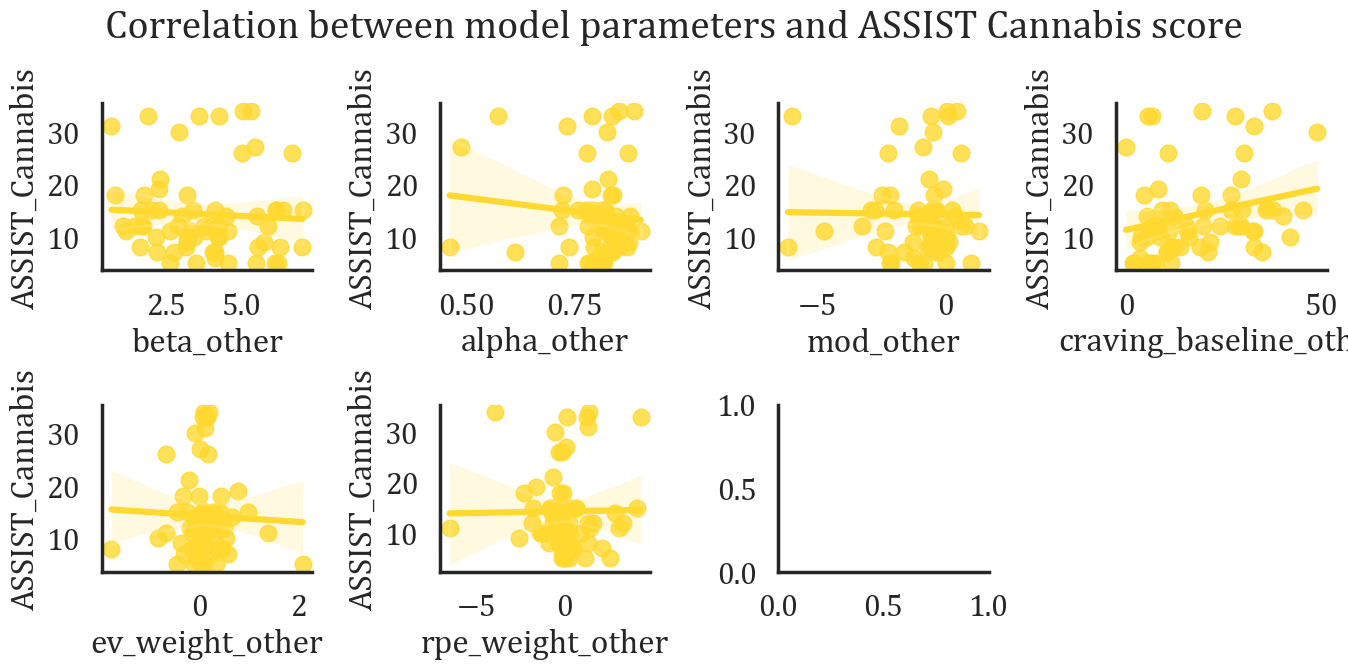

In [17]:
# Seaborn correlation plot
params_to_corr = [param+'_other' for param in ['beta', 'alpha', 'mod','craving_baseline', 'ev_weight', 'rpe_weight']]
pvals = []
fig, ax = plt.subplots(2, 4, figsize=(14,7))
ax = ax.flatten()
for i, param in enumerate(params_to_corr):

    sns.regplot(data=cannabis_merged, x=param, y='ASSIST_Cannabis', ax=ax[i], color=sns.palettes.color_palette('Set2')[5])
    # Annotate with correlation value and p-value
    corr_val, p_val = stats.spearmanr(cannabis_merged[param], cannabis_merged['ASSIST_Cannabis'])
    pvals.append(p_val)
    # ax[i].annotate(f'Corr: {corr_val:.3f}\nP: {p_val:.3f}', xy=(0.1, 0.85), xycoords='axes fraction', color=sns.palettes.color_palette('Set2')[2])
    print(f'Correlation between {param} and ASSIST Cannabis score: {corr_val:.3f}, p-value: {p_val:.3f}')

    

fig.suptitle('Correlation between model parameters and ASSIST Cannabis score')
fig.delaxes(ax[-1])
sns.despine()
plt.tight_layout()

print()
print(f'Corrected p-values: {multipletests(pvals, method="fdr_bh")[1]}')